In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels.formula.api import ols
import researchpy as rp
import os

In [2]:
location = '../../../data/output/non-overlapping_includingbidirectional_all_genes_newannotation'
promoter_pref='promoters_5UTR'
file_names='non-overlapping_includingbidirectional_all_genes_newannotation'
Czechowski_gene_categories = f'../../../data/output/{file_names}/genes/{promoter_pref}_czechowski_constitutive_variable_random.txt'
EPD_TSS_bed = f'../../../data/EPD_promoter_analysis/EPDnew_promoters/At_EPDnew.bed'


In [3]:
#make directory for the plots to be exported to
dirName = f'{location}/rolling_window/TFBS_coverage_rw/plots'
try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " created") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists")

Directory  ../../../data/output/non-overlapping_includingbidirectional_all_genes_newannotation/rolling_window/TFBS_coverage_rw/plots  already exists


In [4]:
#bp_covered = '../../data/promoter_analysis/promoters.bp_covered.txt'
bp_covered = f'{location}/rolling_window/TFBS_coverage_rw/{promoter_pref}_bpcovered_rw.bed'
promoter_bed = f'{location}/FIMO/{promoter_pref}.bed'
promoter_no_5UTR = f'{location}/promoters.gff3'

In [5]:
#bp covered chromatin files
root_chrom_bp_covered = f'../../../data/output/{file_names}/rolling_window/OpenChromatin_rw/{promoter_pref}_root_bpcovered_rw.bed'
shoot_chrom_bp_covered = f'../../../data/output/{file_names}/rolling_window/OpenChromatin_rw/{promoter_pref}_shoot_bpcovered_rw.bed'
rootshootintersect_chrom_bp_covered = f'../../../data/output/{file_names}/rolling_window/OpenChromatin_rw/{promoter_pref}_rootshootintersect_bpcovered_rw.bed'

In [6]:
#read in coverage bedfile
coverage_df = pd.read_table(bp_covered, sep='\t', header=None)
col = ['chr','start','stop','name','no._of_overlaps', 'no._of_bases_covered','window_length','fraction_bases_covered']
coverage_df.columns = col
#add % bases covered column
coverage_df['percentage_bases_covered'] = coverage_df.fraction_bases_covered * 100

In [7]:
coverage_df

,chr,start,stop,name,no._of_overlaps,no._of_bases_covered,window_length,fraction_bases_covered,percentage_bases_covered
0,1,2659,2759,AT1G01010_21,0,0,100,0.00,0.0
1,1,2709,2809,AT1G01010_20,0,0,100,0.00,0.0
2,1,2759,2859,AT1G01010_19,0,0,100,0.00,0.0
3,1,2809,2909,AT1G01010_18,0,0,100,0.00,0.0
4,1,2859,2959,AT1G01010_17,0,0,100,0.00,0.0
...,...,...,...,...,...,...,...,...,...
363248,5,26971348,26971448,AT5G67640_17,0,0,100,0.00,0.0
363249,5,26971398,26971498,AT5G67640_18,0,0,100,0.00,0.0
363250,5,26971448,26971548,AT5G67640_19,2,15,100,0.15,15.0
363251,5,26971498,26971598,AT5G67640_20,2,24,100,0.24,24.0


In [8]:
#allow colour codes in seaborn
sns.set(color_codes=True)
sns.set_style("whitegrid")

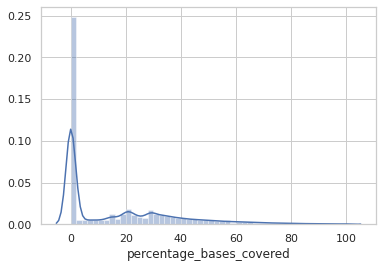

In [9]:
dist_plot = coverage_df['percentage_bases_covered']
#create figure with no transparency
dist_plot_fig = sns.distplot(dist_plot).get_figure()

#save to file
#dist_plot_fig.savefig(f'{location}/TFBS_coverage/plots/bp_covered_dist.pdf', format='pdf')


In [10]:
#Add AGI and window_number column to coverage_df
coverage_df = coverage_df.assign(AGI=coverage_df.name.str.extract(r'(.*?)\_'))
coverage_df['window_number'] = coverage_df.name.str.split('_', n=2, expand = True)[1]
#coverage_df = coverage_df.assign(window_number=coverage_df.name.str[-1:])
coverage_df


,chr,start,stop,name,no._of_overlaps,no._of_bases_covered,window_length,fraction_bases_covered,percentage_bases_covered,AGI,window_number
0,1,2659,2759,AT1G01010_21,0,0,100,0.00,0.0,AT1G01010,21
1,1,2709,2809,AT1G01010_20,0,0,100,0.00,0.0,AT1G01010,20
2,1,2759,2859,AT1G01010_19,0,0,100,0.00,0.0,AT1G01010,19
3,1,2809,2909,AT1G01010_18,0,0,100,0.00,0.0,AT1G01010,18
4,1,2859,2959,AT1G01010_17,0,0,100,0.00,0.0,AT1G01010,17
...,...,...,...,...,...,...,...,...,...,...,...
363248,5,26971348,26971448,AT5G67640_17,0,0,100,0.00,0.0,AT5G67640,17
363249,5,26971398,26971498,AT5G67640_18,0,0,100,0.00,0.0,AT5G67640,18
363250,5,26971448,26971548,AT5G67640_19,2,15,100,0.15,15.0,AT5G67640,19
363251,5,26971498,26971598,AT5G67640_20,2,24,100,0.24,24.0,AT5G67640,20


In [11]:
#remove windows with fewer than 100 promoters extending to that location
coverage_df = coverage_df[coverage_df['window_number'].map(coverage_df['window_number'].value_counts()) > 99]

In [12]:
# def window_plot(coverage_df, ax):
#     """function to plot the window for the length of the windows"""
#     y=coverage_df.percentage_bases_covered
#     x=coverage_df.window_number
    
#     #no_of_windows = int(len(coverage_df.window_number.unique()))
#    # xx = np.arange((no_of_windows * (window_length-window_offset)) - window_length) + window_offset
    

    

In [13]:
len(coverage_df.window_number.unique())

47

In [14]:
def add_coverage(df,coverage_bed,suffix):
    """add % bp covered data from a bed file to the df. Prefix is a name added to any new columns"""
    #read in bed file
    coverage_df = pd.read_table(coverage_bed, sep='\t', header=None)
    cols = ['chr','start','stop','name','no._of_overlaps', 'no._of_bases_covered','window_length','fraction_bases_covered']
    coverage_df.columns = cols
    #add % bases covered column
    coverage_df['percentage_bases_covered'] = coverage_df['fraction_bases_covered'] * 100
    #filter columns
    coverage_df = coverage_df[['chr','start','stop','name','percentage_bases_covered']]
    #make df columns integars
    df = df.astype({'stop':'int','start':'int','chr':'int'})
    coverage_df = coverage_df.astype({'stop':'int','start':'int','chr':'int'})
    #merge the dfs
    merged = pd.merge(df,coverage_df, how='left',on=['chr','start','stop'],suffixes=('', f'_{suffix}'))
    #remove NaN
    #merged = merged[merged['name'].notnull()] 
    return merged

In [15]:
def windows_coords(variable_of_interest,variable_of_interest_name,variable_of_interest_df,promoter_bed,promoter_no_5UTR,
                   window_offset,EPD_TSS_bed,includeEPDTSS=False,chromatin_tissue_variable='percentage_bases_covered_rootshootintersect_chrom',
                   chromatin_tissue_variable_name='% open chromatin root and shoot intersect',x_range=False,estimator='mean', 
                   genetype=False, genetype2=False, genetype3=False):
    """function to add the centre of each window corresponding to each window no. and return a lineplot. Also add promoter length distributio, Araport TSS distribution,
    EPD TSS distribution (add the most common TSS as documented on eukaryotic promoter database Arabidopsis last modified on EPD 06/06/2018)"""
    #read in bed file
    promoter_df = pd.read_table(promoter_bed, sep='\t', header=None)
    col = ['chr','start','stop','AGI','dot1', 'strand','source','type','dot2','attributes']
    promoter_df.columns = col
    #add promoter length column
    promoter_df['length'] = promoter_df.stop-promoter_df.start  
    #merge promoter_bed with variable_of_interest_df on AGI
    merged = pd.merge(variable_of_interest_df, promoter_df, on='AGI',  how='left',suffixes=('','_wholeprom'))
    #remove NaN
    merged = merged[merged[variable_of_interest].notnull()]
    #make columns integars
    merged = merged.astype({'stop_wholeprom':'int','start_wholeprom':'int','start':'int','stop':'int'})
    #split merged into 2 dfs by strand
    pos = merged[merged.strand == '+'].copy()
    neg = merged[merged.strand == '-'].copy()
    
    #add variable of interest position column where position is the middle of the window, with whole length of the longest promoter
    pos['position'] = (pos.stop_wholeprom) - (pos.start+0.5*(pos.stop-pos.start))
    neg['position'] = (neg.start+0.5*(neg.stop-neg.start)) - neg.start_wholeprom
    merged2 = pd.merge(pos,neg,how='outer')

    merged2 = merged2.astype({'position': 'int64'})
    #get longest transcript TSS distribution (if Araport 11 definition used)
    promoter_no_5UTR_df = pd.read_table(promoter_no_5UTR, sep='\t', header=None)
    col = ['chr', 'source', 'type', 'start','stop', 'dot1','strand','dot2','attributes']
    promoter_no_5UTR_df.columns = col
    #add AGI column
    promoter_no_5UTR_df_agi = promoter_no_5UTR_df.assign(AGI=promoter_no_5UTR_df.attributes.str.extract(r'ID=gene:(.*?)\;'))
    #merged with windows    
    merged2 = pd.merge(merged2,promoter_no_5UTR_df_agi, on='AGI', how='left', suffixes=('','_no_UTR'))
    #remove NaN (promoters in promoters.gff but not in promoters_5UTR)
    merged2 = merged2[merged2.length.notnull()]
    #remove NaN (promoters in promoters_5UTR but not in promoters.gff - ie. only 5'UTRs)
    merged2 = merged2[merged2.chr_no_UTR.notnull()]
    #Get most common transcript TSS location from eukaryotic promoter database (last modified on EPD 06/06/2018)
    #Note - not all promoters have a TSS on EPD
    EPD_TSS_df = pd.read_table(EPD_TSS_bed, delim_whitespace=True, header=None, skiprows=4)
    cols = ['chr','start','stop','transcript_EPD','score_EPD','strand_EPD','thickstart_EPD','thickend_EPD']
    EPD_TSS_df.columns = cols
    #add AGI column
    EPD_TSS_df['AGI'] = EPD_TSS_df.transcript_EPD.str.split('_',expand=True)[0]
    #add TSS location column
    EPD_TSS_df.loc[EPD_TSS_df.strand_EPD == '+', 'TSS_EPD'] = EPD_TSS_df.loc[EPD_TSS_df.strand_EPD == '+', 'thickstart_EPD']
    EPD_TSS_df.loc[EPD_TSS_df.strand_EPD == '-', 'TSS_EPD'] = EPD_TSS_df.loc[EPD_TSS_df.strand_EPD == '-', 'thickend_EPD'] -1
    #merged with windows
    merged2 = pd.merge(merged2,EPD_TSS_df, on='AGI', how='left', suffixes=('','_EPD'))

    #remove NaN (promoters in EPD but not in promoters_5UTR)
    merged2 = merged2[merged2.length.notnull()]   
    
    #calculate longest promoter length based on window cutoff
    number_of_windows = len(variable_of_interest_df.window_number.unique())
    window_length = variable_of_interest_df.window_length.max()    
    length_of_longest_promoter = number_of_windows*(window_length-window_offset)

    #make 0 start like in bed files
    merged2.start_no_UTR = merged2.start_no_UTR -1
    #add Araport TSS location column
    #merged2['TSS'] = int()
    merged2.loc[merged2.strand == '+', 'TSS'] = merged2.loc[merged2.strand == '+', 'stop_no_UTR']
    merged2.loc[merged2.strand == '-', 'TSS'] = merged2.loc[merged2.strand == '-', 'start_no_UTR'] -1
    #transform TSS location in the same way as the position column
    merged2.loc[merged2.strand == '-', 'TSS_transformed_Araport11'] = merged2.loc[merged2.strand == '-', 'TSS'] - merged2.loc[merged2.strand == '-','start_wholeprom']
    merged2.loc[merged2.strand == '+', 'TSS_transformed_Araport11'] = merged2.loc[merged2.strand == '+', 'stop_wholeprom'] - merged2.loc[merged2.strand == '+', 'TSS']
    #transfrom PED TSS column in the same way as the position column
    merged2.loc[merged2.strand == '-', 'TSS_transformed_EPD'] = merged2.loc[merged2.strand == '-', 'TSS_EPD'] - merged2.loc[merged2.strand == '-','start_wholeprom']
    merged2.loc[merged2.strand == '+', 'TSS_transformed_EPD'] = merged2.loc[merged2.strand == '+', 'stop_wholeprom'] - merged2.loc[merged2.strand == '+', 'TSS_EPD']
    
    #make integars
    merged2 = merged2.astype({'TSS_transformed_EPD':'float64','start_no_UTR':'float64','stop_no_UTR':'float64','TSS':'float64','TSS_transformed_Araport11':'float64',f'{variable_of_interest}':'float64',f'{chromatin_tissue_variable}':'float64'})
    #return merged2[['AGI','strand','start','stop','start_wholeprom','stop_wholeprom','start_no_UTR','stop_no_UTR','TSS','TSS_transformed','position','chr_no_UTR','window_number']]

    #make all values of interest negative as upstream from ATG
    merged_positive = merged2.copy()
    merged2[['length','TSS_transformed_Araport11','position','TSS_transformed_EPD']] = -merged2[['length','TSS_transformed_Araport11','position','TSS_transformed_EPD']]
    #change estimator
    if estimator == 'mean':
        new_estimator=estimator
        
    if estimator == 'median':
        new_estimator = np.median
    #set number of subplots so can easily change all output possibilities, where subplotA is the top
    subplots = 4
    
    #make subplots
    if includeEPDTSS == True:
        subplots = subplots + 1
        f, axes = plt.subplots(subplots, figsize=(10,10))
        OpenChromplot = axes[subplots-subplots]
        Araport11TSSplot = axes[subplots-(subplots-1)]
        EPDTSSplot = axes[subplots-(subplots-2)]   
        promlengthsplot = axes[subplots-(subplots-3)]
        variableofinterestplot = axes[subplots-(subplots-4)]
    else:
        f, axes = plt.subplots(subplots, figsize=(10,8))
        OpenChromplot = axes[subplots-subplots]
        Araport11TSSplot = axes[subplots-(subplots-1)]
        promlengthsplot = axes[subplots-(subplots-2)]
        variableofinterestplot = axes[subplots-(subplots-3)]

   
    
    #check the plot axes variables are there. If they are not, assign None to them
    try:
        OpenChromplot
    except NameError:
        OpenChromplot = None
    try:
        Araport11TSSplot
    except NameError:
        Araport11TSSplot = None
    try:
        EPDTSSplot
    except NameError:
        EPDTSSplot = None
    try:
        promlengthsplot
    except NameError:
        promlengthsplot = None
    try:
        variableofinterestplot
    except NameError:
        variableofinterestplot = None
    
    #If EPD TSS plot is present, filter promoters which aren't in EPD to remove NaNs
    if EPDTSSplot != None:
        #remove NaN (promoters in promoters_5UTR but not in promoters.gff - ie. only 5'UTRs)
        merged2 = merged2[merged2.TSS_transformed_EPD.notnull()]
    
    
    

    if genetype==False:
        
        #length_of_longest_promoter = merged_positive.length.max()
        #if openchromplot variable present, add that plot

        if OpenChromplot !=None:
            #Open chromatin lineplot
            sns.lineplot(y=merged2[chromatin_tissue_variable],x=merged2.position,ax=OpenChromplot,estimator=new_estimator)
            #set titles and axes labels
            OpenChromplot.set_title(f'All promoters {chromatin_tissue_variable_name}', weight='bold')
            OpenChromplot.set_ylabel(f'{estimator} % open chromatin')
            OpenChromplot.set_xlabel('')
            OpenChromplot.set_xticklabels([])  
        
        #if Araport11TSSplot variable present, add that plot
        if Araport11TSSplot !=None:
            #AraportTSS distribution
            sns.distplot(merged2.TSS_transformed_Araport11, ax=Araport11TSSplot)
            #set titles and axes labels
            Araport11TSSplot.set_title(f'All promoters Araport11 TSS distribution', weight='bold')
            #density is kernal density estimation
            Araport11TSSplot.set_ylabel('Density')
            Araport11TSSplot.set_xlabel('')
            Araport11TSSplot.set_xticklabels([])
        
        #if includeEPDTSS variable present, add that plot
        if includeEPDTSS ==True:
            #EPDTSS distribution
            sns.distplot(merged2.TSS_transformed_EPD, ax=EPDTSSplot)
            #set titles and axes labels
            EPDTSSplot.set_title(f'All promoters EPD TSS distribution', weight='bold')
            EPDTSSplot.set_ylabel('Density')
            EPDTSSplot.set_xlabel('')
            EPDTSSplot.set_xticklabels([])  
        
        #if promlengthsplot variable present, add that plot
        if promlengthsplot !=None:
            #promoter length dist_plot
            sns.distplot(merged2.length, ax=promlengthsplot)
            #set titles and axes labels
            promlengthsplot.set_title(f'All promoters length distribution', weight='bold')  
            promlengthsplot.set_ylabel('Density')
            promlengthsplot.set_xlabel('')
            promlengthsplot.set_xticklabels([])
        #if variableofinterestplot variable present, add that plot
        if variableofinterestplot !=None:
            #variable of interest lineplot
            sns.lineplot(y=merged2[variable_of_interest], x=merged2.position, ax=variableofinterestplot,estimator=new_estimator) 
            #set titles and axes labels
            variableofinterestplot.set_title(f'All promoters sliding windows {variable_of_interest_name}', weight='bold')
            variableofinterestplot.set_ylabel(f'{estimator} {variable_of_interest_name}')
            variableofinterestplot.set_xlabel('position upstream of ATG')

               
    elif genetype2==False:
        #filter so only genetype subset present
        merged2 = merged2[merged2.gene_type.notnull()]
        #if openchromplot variable present, add that plot
        if OpenChromplot !=None:        
            #Open chromatin lineplot
            sns.lineplot(y=merged2[merged2.gene_type == genetype][chromatin_tissue_variable],x=merged2[merged2.gene_type == genetype].position,ax=OpenChromplot,estimator=new_estimator)
            #set titles and axes labels
            OpenChromplot.set_title(f'{genetype} {chromatin_tissue_variable_name}', weight='bold')
            OpenChromplot.set_ylabel(f'{estimator} % open chromatin')
            OpenChromplot.set_xlabel('')
            OpenChromplot.set_xticklabels([]) 
            
        #if Araport11TSSplot variable present, add that plot
        if Araport11TSSplot !=None:
            #Araport11 TSS distribution
            sns.distplot(merged2[merged2.gene_type == genetype].TSS_transformed_Araport11, ax=Araport11TSSplot)
            #set titles and axes labels
            Araport11TSSplot.set_title(f'{genetype} Araport11 TSS distribution', weight='bold')
            #density is kernal density estimation
            Araport11TSSplot.set_ylabel('Density')
            Araport11TSSplot.set_xlabel('')
            Araport11TSSplot.set_xticklabels([])
        #if includeEPDTSS variable present, add that plot
        if includeEPDTSS ==True:
            #EPD TSS distribution
            sns.distplot(merged2[merged2.gene_type == genetype].TSS_transformed_EPD, ax=EPDTSSplot)
            #set titles and axes labels
            EPDTSSplot.set_title(f'{genetype} EPD TSS distribution', weight='bold')
            EPDTSSplot.set_ylabel('Density')
            EPDTSSplot.set_xlabel('')
            EPDTSSplot.set_xticklabels([])  
        
        #if promlengthsplot variable present, add that plot
        if promlengthsplot !=None:
            #promoter length dist_plot
            sns.distplot(merged2[merged2.gene_type == genetype].length, ax=promlengthsplot)
            #set titles and axes labels
            promlengthsplot.set_title(f'{genetype} promoter length distribution', weight='bold')  
            promlengthsplot.set_ylabel('Density')
            promlengthsplot.set_xlabel('')
            promlengthsplot.set_xticklabels([])
        
        #if variableofinterestplot variable present, add that plot
        if variableofinterestplot !=None:
            #variable of interest lineplot
            sns.lineplot(y=merged2[merged2.gene_type == genetype][variable_of_interest], x=merged2[merged2.gene_type == genetype].position, ax=variableofinterestplot, estimator=new_estimator) 
            #set titles and axes labels
            variableofinterestplot.set_title(f'{genetype} {variable_of_interest_name}', weight='bold')
            variableofinterestplot.set_ylabel(f'{estimator} {variable_of_interest_name}')
            variableofinterestplot.set_xlabel('position upstream of ATG')
        
        #set y axis as maximum mean window % bp covered of all genetype subset        
        #variableofinterestplot.set_ylim([0,merged2.groupby('window_number')[variable_of_interest].median().max()+20])
        #set x axis range if specified 
#         if x_range==False:
#             pass
#         else:
#             length_of_longest_promoter = x_range
        
#         #for all subplots:
#         for n in axes:
#             #remove grids
#             n.grid(False)
#             n.set_xlim([-length_of_longest_promoter,0])        
#         f.tight_layout()
        
    elif genetype3==False:
        #filter so only genetype subset present
        merged2 = merged2[merged2.gene_type.notnull()]
        #if openchromplot variable present, add that plot
        if OpenChromplot !=None:                      
            #Open chromatin lineplot
            sns.lineplot(y=merged2[merged2.gene_type == genetype][chromatin_tissue_variable],x=merged2[merged2.gene_type == genetype].position,ax=OpenChromplot,estimator=new_estimator,label=genetype)
            sns.lineplot(y=merged2[merged2.gene_type == genetype2][chromatin_tissue_variable],x=merged2[merged2.gene_type == genetype2].position,ax=OpenChromplot,estimator=new_estimator,label=genetype2)
            #set titles & axes names
            OpenChromplot.set_title(f'{chromatin_tissue_variable_name}', weight='bold')
            OpenChromplot.set_ylabel(f'{estimator} % open chromatin')
            OpenChromplot.set_xlabel('')           
            OpenChromplot.set_xticklabels([])
        #if Araport11TSSplot variable present, add that plot
        if Araport11TSSplot !=None:
            #Araport TSS distribution
            sns.distplot(merged2[merged2.gene_type == genetype].TSS_transformed_Araport11, ax=Araport11TSSplot,hist=None,label=genetype)
            sns.distplot(merged2[merged2.gene_type == genetype2].TSS_transformed_Araport11, ax=Araport11TSSplot,hist=None,label=genetype2)
            #set titles & axes names
            Araport11TSSplot.set_title(f'Araport11 TSS distribution', weight='bold')
            #density is kernal density estimation
            Araport11TSSplot.set_ylabel('Density')
            Araport11TSSplot.set_xlabel('')
            Araport11TSSplot.set_xticklabels([])
        #if includeEPDTSS variable present, add that plot
        if includeEPDTSS ==True:
            #EPD TSS distribution
            sns.distplot(merged2[merged2.gene_type == genetype].TSS_transformed_EPD, ax=EPDTSSplot,hist=None,label=genetype)
            sns.distplot(merged2[merged2.gene_type == genetype2].TSS_transformed_EPD, ax=EPDTSSplot,hist=None,label=genetype2)
            #set titles & axes names
            EPDTSSplot.set_title(f'{genetype} EPD TSS distribution', weight='bold')
            EPDTSSplot.set_ylabel('Density')
            EPDTSSplot.set_xlabel('')
            EPDTSSplot.set_xticklabels([])
        #if promlengthsplot variable present, add that plot
        if promlengthsplot !=None:
            #promoter length dist_plot
            sns.distplot(merged2[merged2.gene_type == genetype].length, ax=promlengthsplot,hist=None,label=genetype)
            sns.distplot(merged2[merged2.gene_type == genetype2].length, ax=promlengthsplot,hist=None,label=genetype2)
            #set titles & axes names        
            promlengthsplot.set_title(f'promoter length distribution', weight='bold')  
            promlengthsplot.set_ylabel('Density')
            promlengthsplot.set_xlabel('')
            promlengthsplot.set_xticklabels([])
        #if variableofinterestplot variable present, add that plot
        if variableofinterestplot !=None:
            #lineplot variable of interest
            l1=sns.lineplot(y=merged2[merged2.gene_type == genetype][variable_of_interest], x=merged2[merged2.gene_type == genetype].position, ax=variableofinterestplot,label=genetype,estimator=new_estimator)
            l2=sns.lineplot(y=merged2[merged2.gene_type == genetype2][variable_of_interest], x=merged2[merged2.gene_type == genetype2].position, ax=variableofinterestplot,label=genetype2,estimator=new_estimator) 
            #set titles & axes names
            variableofinterestplot.set_title(f'{variable_of_interest_name}', weight='bold')
            variableofinterestplot.set_ylabel(f'{estimator} {variable_of_interest_name}')
            variableofinterestplot.set_xlabel('position upstream of ATG')
        #set y axis as maximum mean window % bp covered of all genetype subset        
        #axes[2].set_ylim([0,merged2.groupby('window_number').percentage_bases_covered.median().max()+20])
        #gene_type labels
        gene_type_labels = [genetype, genetype2]
        # Create the legend
        axes[0].legend()

#         if x_range==False:
#             pass
#         else:
#             length_of_longest_promoter = x_range

#         #for all subplots:
#         for n in axes:
#             #remove grids
#             n.grid(False)
#             n.set_xlim([-length_of_longest_promoter,0])
#         f.tight_layout()
    else:
        #filter so only genetype subset present
        merged2 = merged2[merged2.gene_type.notnull()]
        #if openchromplot variable present, add that plot
        if OpenChromplot !=None:                      
            #Open chromatin lineplot
            sns.lineplot(y=merged2[merged2.gene_type == genetype][chromatin_tissue_variable],x=merged2[merged2.gene_type == genetype].position,ax=OpenChromplot,estimator=new_estimator,label=genetype)
            sns.lineplot(y=merged2[merged2.gene_type == genetype2][chromatin_tissue_variable],x=merged2[merged2.gene_type == genetype2].position,ax=OpenChromplot,estimator=new_estimator,label=genetype2)
            sns.lineplot(y=merged2[merged2.gene_type == genetype3][chromatin_tissue_variable],x=merged2[merged2.gene_type == genetype3].position,ax=OpenChromplot,estimator=new_estimator,label=genetype3)
            #set titles & axes names 
            OpenChromplot.set_title(f'{chromatin_tissue_variable_name}', weight='bold')
            OpenChromplot.set_ylabel(f'{estimator} % open chromatin')
            OpenChromplot.set_xlabel('')           
            OpenChromplot.set_xticklabels([])          
        #if Araport11TSSplot variable present, add that plot
        if Araport11TSSplot !=None:
            #Araport11 TSS distribution
            sns.distplot(merged2[merged2.gene_type == genetype].TSS_transformed_Araport11, ax=Araport11TSSplot,hist=None,label=genetype)
            sns.distplot(merged2[merged2.gene_type == genetype2].TSS_transformed_Araport11, ax=Araport11TSSplot,hist=None,label=genetype2)
            sns.distplot(merged2[merged2.gene_type == genetype3].TSS_transformed_Araport11, ax=Araport11TSSplot,hist=None,label=genetype3)
            #set titles & axes names
            Araport11TSSplot.set_title(f'Araport11 TSS distribution', weight='bold')
            #density is kernal density estimation
            Araport11TSSplot.set_ylabel('Density')
            Araport11TSSplot.set_xlabel('')
            Araport11TSSplot.set_xticklabels([])
        #if includeEPDTSS variable present, add that plot
        if includeEPDTSS ==True:
            #EPD TSS distribution
            sns.distplot(merged2[merged2.gene_type == genetype].TSS_transformed_EPD, ax=EPDTSSplot,hist=None,label=genetype)
            sns.distplot(merged2[merged2.gene_type == genetype2].TSS_transformed_EPD, ax=EPDTSSplot,hist=None,label=genetype2)
            sns.distplot(merged2[merged2.gene_type == genetype3].TSS_transformed_EPD, ax=EPDTSSplot,hist=None,label=genetype3)
            #set titles & axes names
            EPDTSSplot.set_title(f'EPD TSS distribution', weight='bold')
            EPDTSSplot.set_ylabel('Density')
            EPDTSSplot.set_xlabel('')
            EPDTSSplot.set_xticklabels([])  
        #if promlengthsplot variable present, add that plot
        if promlengthsplot !=None:
            #promoter length dist_plot
            sns.distplot(merged2[merged2.gene_type == genetype].length, ax=promlengthsplot,hist=None,label=genetype)
            sns.distplot(merged2[merged2.gene_type == genetype2].length, ax=promlengthsplot,hist=None,label=genetype2)
            sns.distplot(merged2[merged2.gene_type == genetype3].length, ax=promlengthsplot,hist=None,label=genetype3)
            #set titles & axes names 
            promlengthsplot.set_title(f'promoter length distribution', weight='bold')  
            promlengthsplot.set_ylabel('Density')
            promlengthsplot.set_xlabel('')
            promlengthsplot.set_xticklabels([])
        #if variableofinterestplot variable present, add that plot
        if variableofinterestplot !=None:
            #lineplot
            l1=sns.lineplot(y=merged2[merged2.gene_type == genetype][variable_of_interest], x=merged2[merged2.gene_type == genetype].position, ax=variableofinterestplot, label=genetype,estimator=new_estimator)
            l2=sns.lineplot(y=merged2[merged2.gene_type == genetype2][variable_of_interest], x=merged2[merged2.gene_type == genetype2].position, ax=variableofinterestplot,label=genetype2,estimator=new_estimator)
            l3=sns.lineplot(y=merged2[merged2.gene_type == genetype3][variable_of_interest], x=merged2[merged2.gene_type == genetype3].position, ax=variableofinterestplot,label=genetype3,estimator=new_estimator)
            #set titles & axes names      
            variableofinterestplot.set_title(f'{variable_of_interest_name}', weight='bold')
            variableofinterestplot.set_ylabel(f'{estimator} {variable_of_interest_name}')
            variableofinterestplot.set_xlabel('position upstream of ATG')
        #set y axis as maximum mean window % bp covered of all genetype subset        
        #axes[2].set_ylim([0,merged2.groupby('window_number').percentage_bases_covered.median().max()+20])
        #gene_type labels
        gene_type_labels = [genetype, genetype2, genetype3]
        # Create the legend
        axes[0].legend()
        #set x axis length
#         if x_range==False:
#             pass
#         else:
#             length_of_longest_promoter = x_range

        
#         #for all subplots:
#         for n in axes:
#             #remove grids
#             n.grid(False)
#             n.set_xlim([-length_of_longest_promoter,0])
#             leg = n.legend()
#         f.tight_layout()
    #set x axis range if specified    
    if x_range==False:
        pass
    else:
        length_of_longest_promoter = x_range
        
    #for all subplots:
    for n in axes:
        #remove grids
        n.grid(False)
        n.set_xlim([-length_of_longest_promoter,0])
    #set a tight layout
    f.tight_layout()
    
    return merged2

In [16]:
#add root chromatin coverage data
coverage_df = add_coverage(coverage_df, root_chrom_bp_covered,'root_chrom')
#add shoot chromatin coverage data
coverage_df = add_coverage(coverage_df, shoot_chrom_bp_covered,'shoot_chrom')
#add rootshootintersect chromatin coverage data
coverage_df = add_coverage(coverage_df, rootshootintersect_chrom_bp_covered,'rootshootintersect_chrom')

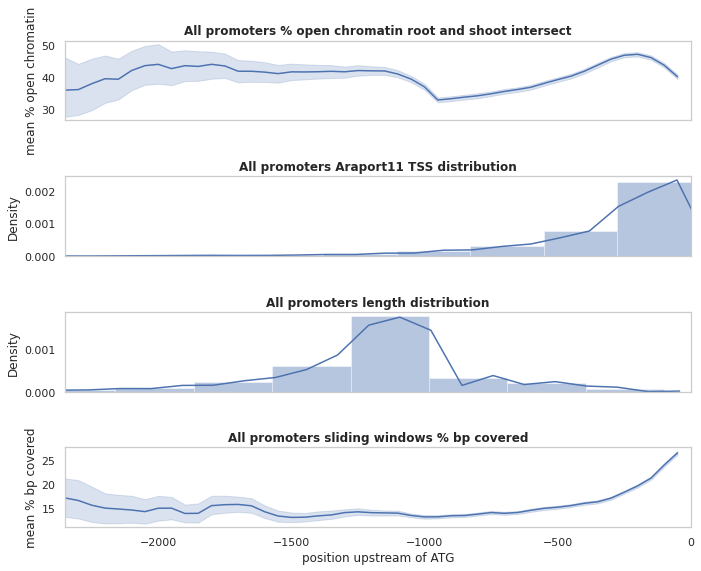

In [17]:
#all promoters in genome
merged = windows_coords('percentage_bases_covered','% bp covered',coverage_df,promoter_bed,promoter_no_5UTR, 50,EPD_TSS_bed)

## Now do constitutive and variable promoter from Czechowski et al 2005

In [18]:
def add_genetype(coverage,gene_categories):
    """function to add gene type to the df, and remove random genes"""
    select_genes = pd.read_table(gene_categories, sep='\t', header=None)
    cols = ['AGI', 'gene_type']
    select_genes.columns = cols

    merged = pd.merge(select_genes, coverage, on='AGI', how='left')   
   # no_random = merged_renamed[merged_renamed.gene_type != 'random']
  #  no_random.reset_index(drop=True, inplace=True)
    
    return merged

In [19]:
coverage_prom_types = add_genetype(coverage_df, Czechowski_gene_categories)

In [20]:
coverage_prom_types

,AGI,gene_type,chr,start,stop,name,no._of_overlaps,no._of_bases_covered,window_length,fraction_bases_covered,percentage_bases_covered,window_number,name_root_chrom,percentage_bases_covered_root_chrom,name_shoot_chrom,percentage_bases_covered_shoot_chrom,name_rootshootintersect_chrom,percentage_bases_covered_rootshootintersect_chrom
0,AT4G34270,constitutive,4,16406153,16406253,AT4G34270_1,0,0,100,0.0,0.0,1,AT4G34270_1,100.0,AT4G34270_1,100.0,AT4G34270_1,100.0
1,AT4G34270,constitutive,4,16406203,16406303,AT4G34270_2,0,0,100,0.0,0.0,2,AT4G34270_2,100.0,AT4G34270_2,100.0,AT4G34270_2,100.0
2,AT4G34270,constitutive,4,16406253,16406353,AT4G34270_3,0,0,100,0.0,0.0,3,AT4G34270_3,100.0,AT4G34270_3,100.0,AT4G34270_3,100.0
3,AT4G34270,constitutive,4,16406303,16406403,AT4G34270_4,0,0,100,0.0,0.0,4,AT4G34270_4,100.0,AT4G34270_4,100.0,AT4G34270_4,100.0
4,AT4G34270,constitutive,4,16406353,16406453,AT4G34270_5,0,0,100,0.0,0.0,5,AT4G34270_5,100.0,AT4G34270_5,100.0,AT4G34270_5,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5679,AT4G39950,control,4,18524814,18524914,AT4G39950_5,0,0,100,0.0,0.0,5,AT4G39950_5,100.0,AT4G39950_5,35.0,AT4G39950_5,35.0
5680,AT4G39950,control,4,18524864,18524964,AT4G39950_4,0,0,100,0.0,0.0,4,AT4G39950_4,100.0,AT4G39950_4,85.0,AT4G39950_4,85.0
5681,AT4G39950,control,4,18524914,18525014,AT4G39950_3,0,0,100,0.0,0.0,3,AT4G39950_3,100.0,AT4G39950_3,100.0,AT4G39950_3,100.0
5682,AT4G39950,control,4,18524964,18525064,AT4G39950_2,0,0,100,0.0,0.0,2,AT4G39950_2,100.0,AT4G39950_2,100.0,AT4G39950_2,100.0


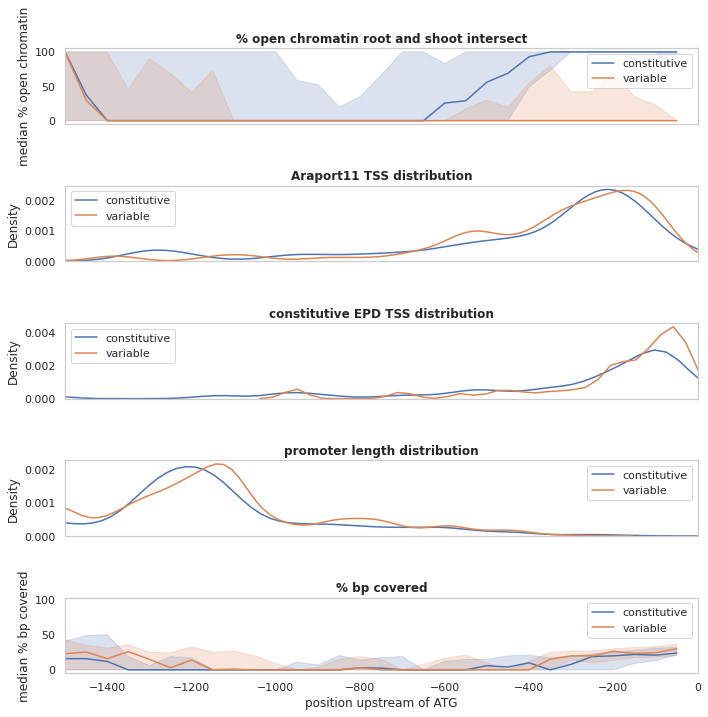

In [22]:
rolling_rootshootintersect = windows_coords('percentage_bases_covered','% bp covered',coverage_prom_types,promoter_bed,promoter_no_5UTR,
                         50,EPD_TSS_bed, includeEPDTSS=True, x_range=1500,estimator='median',  genetype='constitutive', genetype2='variable')
#figure legend:
# 1) Sliding windows of 100bp with 50bp offset were taken across each promoter. 
# 2) Window 1 is the 100bp immediately upstream of the ATG. Window 2 is offset 50bp further upstream of this and so on.
# 3) The coordinate of the middle of each window was used for each data point on the plot x axis
# 4) % bp covered by TFBSs in each window were calculated. The mean % bp covered for each window position (ie. mean of all window 1s, mean of all window 2s etc) across all promoters was calculated and used for the y-axis
# 5) The x-axis range was set to the longest promoter in the dataset
# 6) 95% confidence intervals

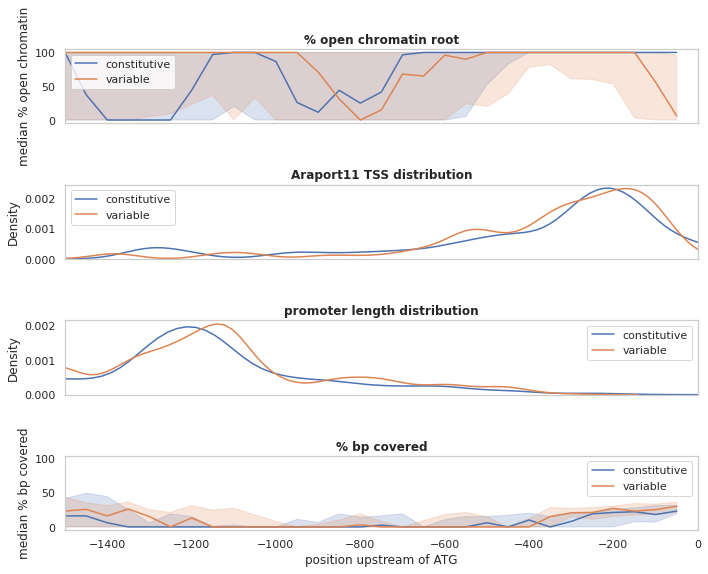

In [23]:
rolling_rootchrom = windows_coords('percentage_bases_covered','% bp covered',coverage_prom_types,promoter_bed,promoter_no_5UTR,
                         50,EPD_TSS_bed,chromatin_tissue_variable='percentage_bases_covered_root_chrom',
                   chromatin_tissue_variable_name='% open chromatin root',x_range=1500,estimator='median',  genetype='constitutive', genetype2='variable')

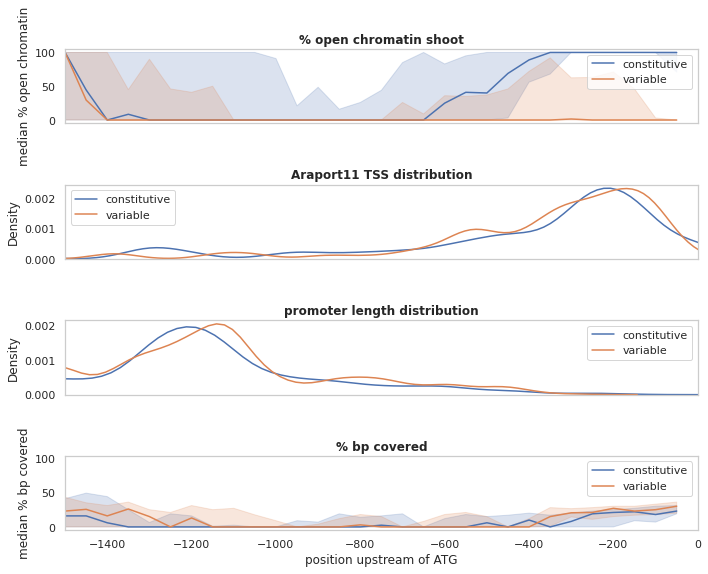

In [24]:
rolling_shootchrom = windows_coords('percentage_bases_covered','% bp covered',coverage_prom_types,promoter_bed,promoter_no_5UTR,
                         50,EPD_TSS_bed,chromatin_tissue_variable='percentage_bases_covered_shoot_chrom',
                   chromatin_tissue_variable_name='% open chromatin shoot',x_range=1500,estimator='median',  genetype='constitutive', genetype2='variable')

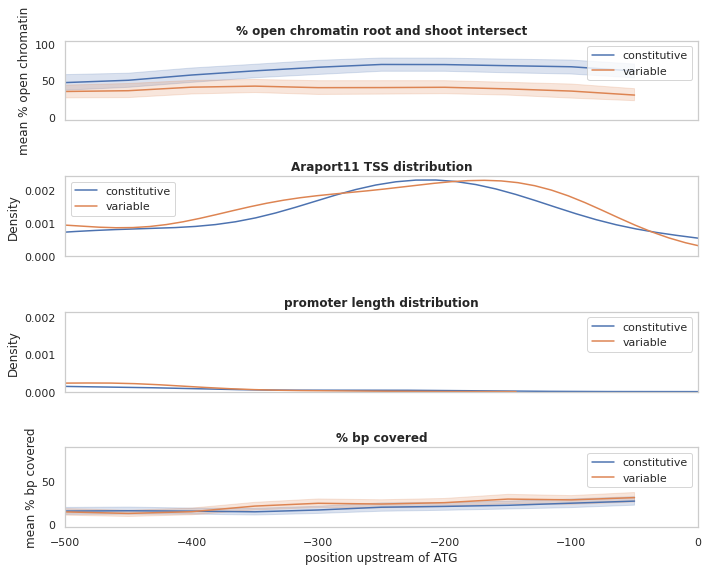

In [25]:
rolling = windows_coords('percentage_bases_covered','% bp covered',coverage_prom_types,promoter_bed,promoter_no_5UTR, 50,EPD_TSS_bed,x_range=500,estimator='mean',  genetype='constitutive', genetype2='variable')

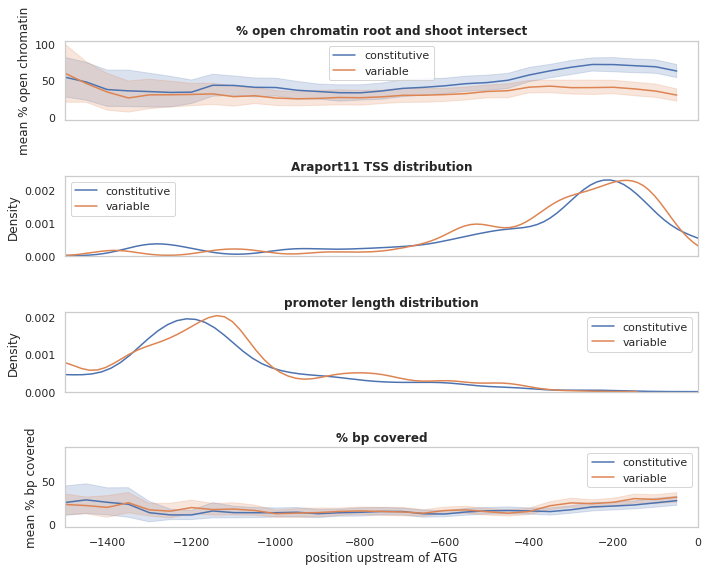

In [26]:
rolling_mean = windows_coords('percentage_bases_covered','% bp covered',coverage_prom_types,promoter_bed,promoter_no_5UTR, 50,EPD_TSS_bed,x_range=1500,estimator='mean',  genetype='constitutive', genetype2='variable')

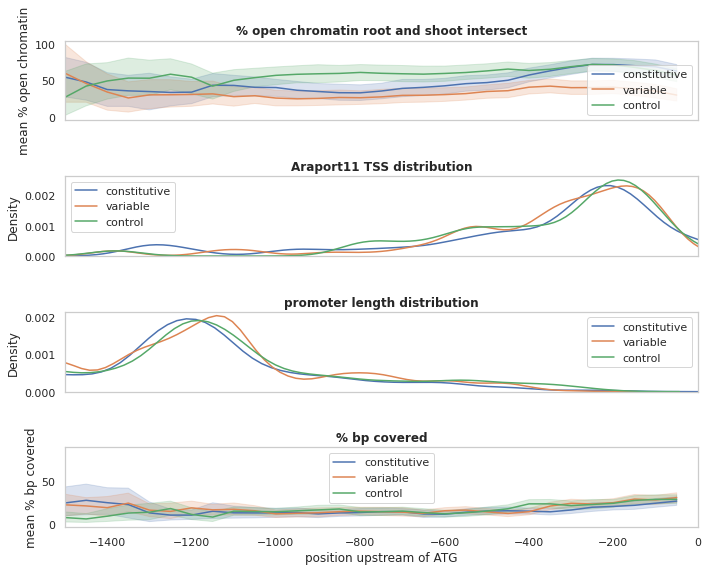

In [27]:
rolling_incl_control = windows_coords('percentage_bases_covered','% bp covered',coverage_prom_types,promoter_bed,promoter_no_5UTR, 50,EPD_TSS_bed,x_range=1500,estimator='mean',  genetype='constitutive', genetype2='variable', genetype3='control')

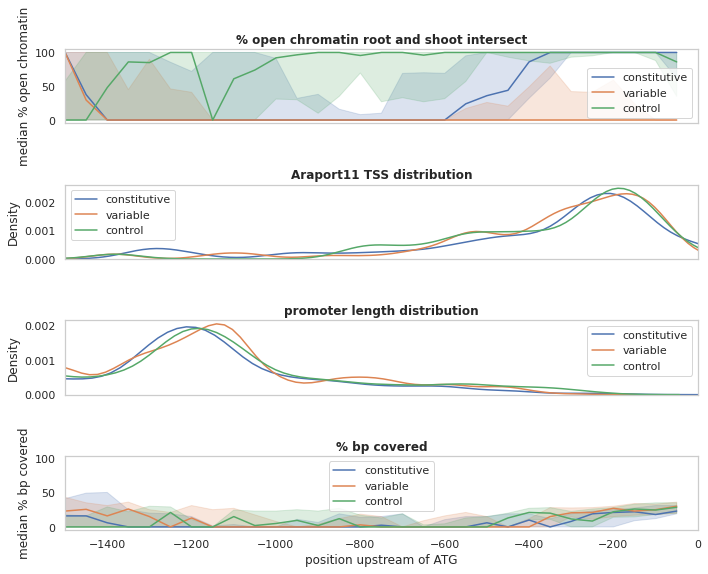

In [28]:
rolling_incl_control = windows_coords('percentage_bases_covered','% bp covered',coverage_prom_types,promoter_bed,promoter_no_5UTR, 50,EPD_TSS_bed,estimator='median',x_range=1500,  genetype='constitutive', genetype2='variable', genetype3='control')